In [83]:
using LinearAlgebra
using Arpack
using Plots
using SparseArrays
using Combinatorics

# Automata method for SOW on the triangular lattice

In this notebook, we present the code used to obtain upper bounds for the connective constant of self-osculating walks (SOWs) on the triangular lattice.  
The implementation follows the method described in Section 3 of [our work](https://arxiv.org/pdf/2509.04568) and is used to produce the upper bounds reported in **Table 5**.

# Plots

Below, we show code to plot a single walk, a list of walks, and the allowed vertices in self-osculating walks (SOWs).

In [84]:
"""
plot_walk(walk)

Plot a single walk in a separate figure using quiver for better arrows.

Arguments
walk: A collection of coordinates representing the path of the walk. Each element should be a tuple (x, y) or similar.

Returns
Nothing. The function produces a plot of the walk.
"""
function plot_walk(walk)
    x = [w[1] for w in walk]
    y = [w[2] for w in walk]

    fig = plot(x, y, marker=:circle, color=:blue, linewidth=2, markersize=5,
               xlabel="X", ylabel="Y", label="Path")  # main path

    # Start and end points
    scatter!(fig, [x[1]], [y[1]], color=:green, markersize=8, label="Start")
    scatter!(fig, [x[end]], [y[end]], color=:red, markersize=8, label="End")

    # Quiver arrows along the path
    dx = diff(x)
    dy = diff(y)
    quiver!(fig, x[1:end-1], y[1:end-1], quiver=(dx, dy), color=:blue, label="")

    # Annotate step numbers at midpoints
    for i in 1:length(dx)
        mid_x = (x[i] + x[i+1]) / 2
        mid_y = (y[i] + y[i+1]) / 2
        annotate!(fig, mid_x, mid_y + 0.1, text("$i", 10, :black))
    end

    display(fig)
end

"""
plot_all_walks(walks)

Plot each walk in a separate figure.

Arguments
walks: A collection (e.g., array) of walks, where each walk is a collection of coordinates (tuples of x, y).

Returns
Nothing. The function produces one figure per walk.
"""
function plot_all_walks(walks)
    """Plot each walk in a separate figure."""
    if isempty(walks)
        println("No valid walks found.")
        return
    end

    for walk in walks
        plot_walk(walk)  # Plot each walk
    end
end

plot_all_walks

In [85]:
"""
plot_vertices(allowed_vertices, x, y)

Plot allowed vertices around a given point (x, y). Each set of vertices is displayed in a separate figure with colored segments and a square centered at (x, y).

Arguments
allowed_vertices: A collection of vertex sets to plot.
x: The x-coordinate of the central reference point.
y: The y-coordinate of the central reference point.

Returns
Nothing. The function produces a plot for each vertex set.
"""
function plot_vertices(allowed_vertices,x,y)

    colors = [:red, :blue, :orange]

    # Hexagon
    xs = [1,2,1,-1,-2,-1,1]
    ys = [-1,-0,1,1,0,-1,-1]
    
    for vertex_set in allowed_vertices
        plt = plot(legend = false)
        for (i, s) in enumerate(vertex_set)
            points = collect(s)
            color = colors[mod1(i, length(colors))]
            if length(points) == 2
                x_coords_1 = [points[1][1], x]
                y_coords_1 = [points[1][2], y]
                x_coords_2 = [x, points[2][1]]
                y_coords_2 = [y, points[2][2]]
                plot!(x_coords_1, y_coords_1, lw=2, color=color)
                plot!(x_coords_2, y_coords_2, lw=2, color=color)
                plot!(xs, ys, lw = 2, aspect_ratio = :equal, color = RGB(0.282, 0.863, 0.655), legend = false)
            else
                error("Segment not found")
            end
        end
        display(plt)
    end
end

plot_vertices

# Allowed Vertices

Below we define the allowed vertices in SOW on the triangular lattice and plot them.

Normally, the basis vectors for the triangular lattice are those connecting the origin, $(0,0)$, with $(1/2, \sqrt{3}/2)$ and $(1,0)$. However, it is not convenient to use lattice points with non-integer coordinates, since they complicate the coding.  

Instead, we apply a **lattice-squeezing transformation** so that the fundamental triangle is mapped to integer coordinates, namely the vertices  
$$
(0,0), \quad (1,1), \quad (2,1).
$$


In [86]:
"""
rotate_point(x, y, n)

Rotate a point (x, y) by n * 60 degrees (π/3 radians) counterclockwise.

A lattice-squeezing transformation is applied so that the resulting lattice points
remain at integer coordinates (avoiding floating-point precision issues).

Arguments
x: The x-coordinate of the point.
y: The y-coordinate of the point.
n: The number of 60-degree rotations to apply.

Returns
(xrot, yrot): The rotated point as integers.
"""
function rotate_point(x,y,n)

    n = n%6
    if n==0
        return (x,y)
    end

    if n==1
        return (x/2 + (3y)/2, -(x/2) + y/2)
    end

    if n==2
        return (-x/2 + (3y)/2, -(x/2) - y/2)
    end

    if n==3
        return (-x , -y)
    end

    if n==4
        return (-x/2 - (3y)/2, (x/2) - y/2)
    end

    if n==5
        return (x/2 - (3y)/2, (x/2) + y/2)
    end


end

rotate_point

In [87]:
vertex_1 = Set([Set([(-1, 1),(1, 1)]), Set([(-1, -1),(1, -1)]), Set([(-2,0),(2,0)])]) 

vertex_2 = Set([Set([(-1, 1),(-1, -1)]), Set([(1, 1),(1, -1)])]) 

vertex_3 = Set([Set([(-1, 1),(1, 1)]), Set([(2, 0),(1, -1)]),Set([(-2,0),(-1, -1)])])

vertex_4 = Set([Set([(-1, 1),(-1, -1)]), Set([(1, 1),(2, 0)])]) 


allowed_vertices = Set([vertex_1,vertex_2,vertex_3,vertex_4])
for vertex_set in copy(allowed_vertices)
    for a in 1:5
        rotated_coords = Set([Set([rotate_point(x, y, a) for (x, y) in s]) for s in vertex_set])
        push!(allowed_vertices, rotated_coords)
    end

    for a in 0:5
        rotated_coords = Set([Set([rotate_point(x, -y, a) for (x, y) in s]) for s in vertex_set])
        push!(allowed_vertices, rotated_coords)
    end
end

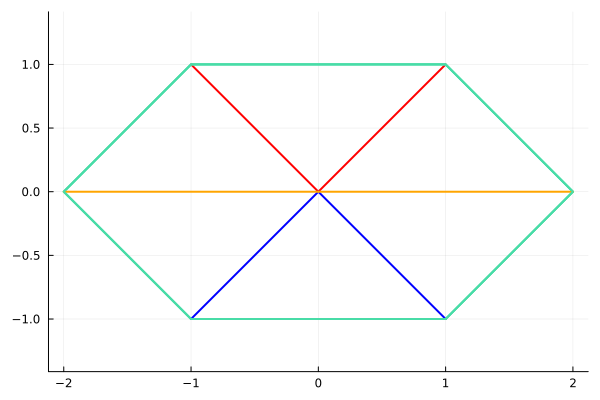

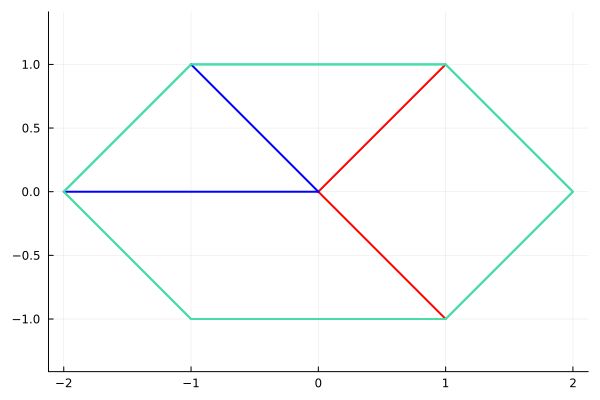

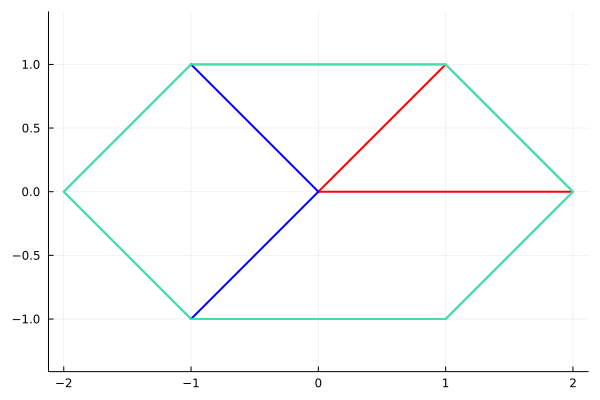

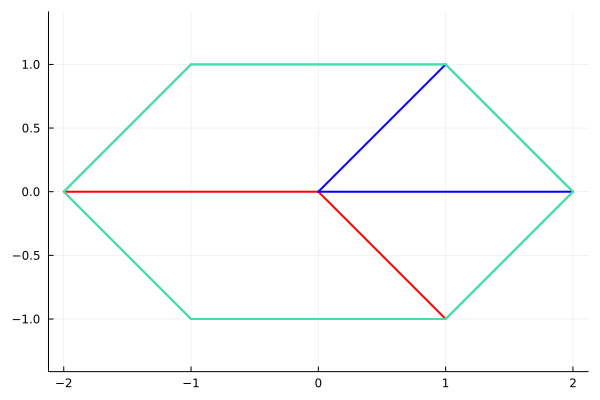

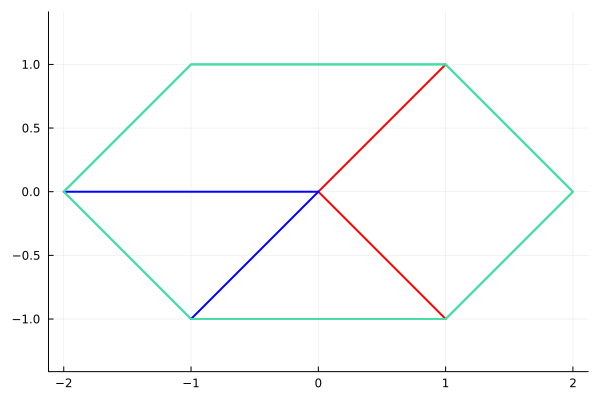

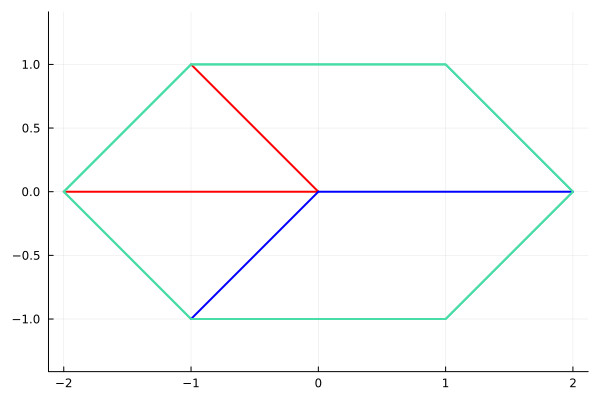

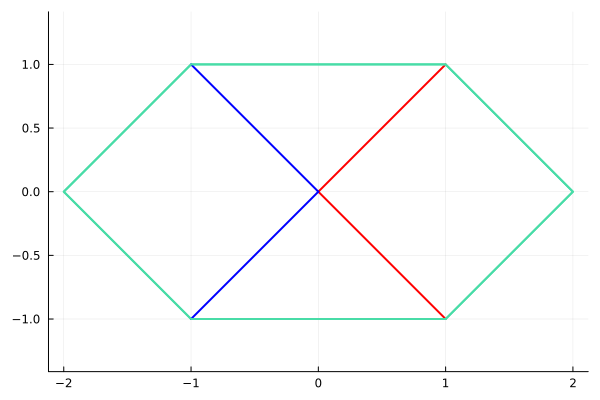

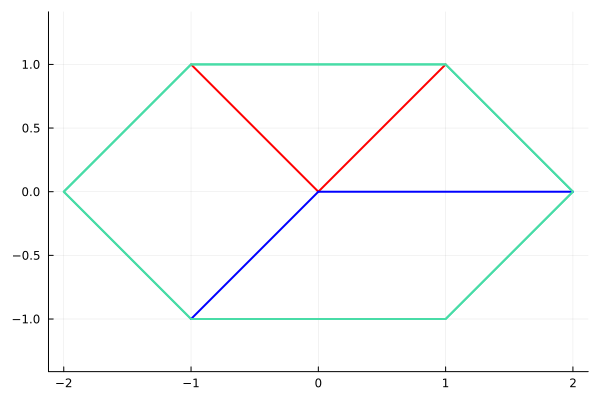

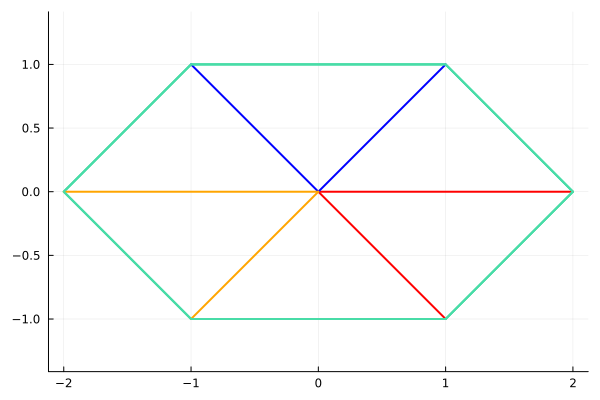

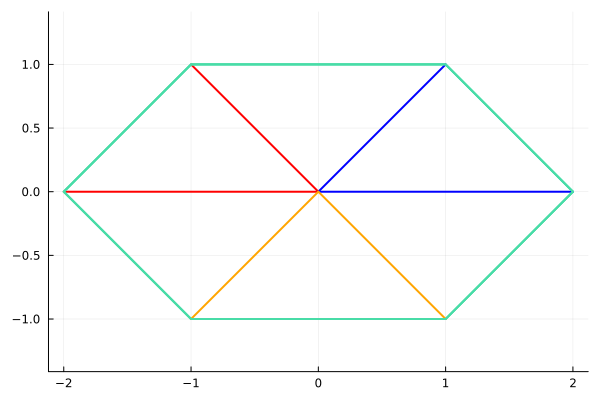

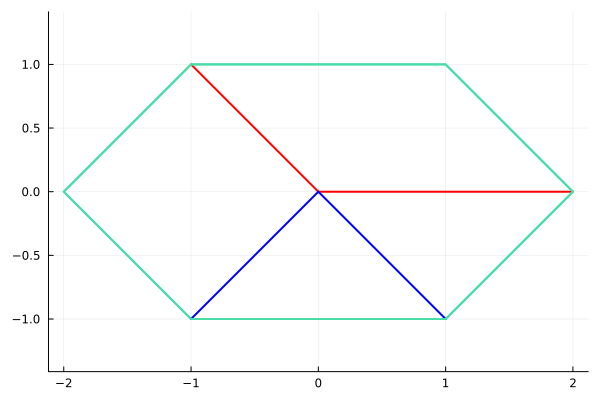

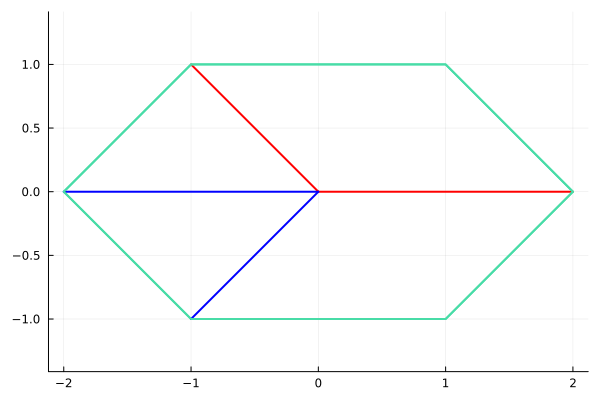

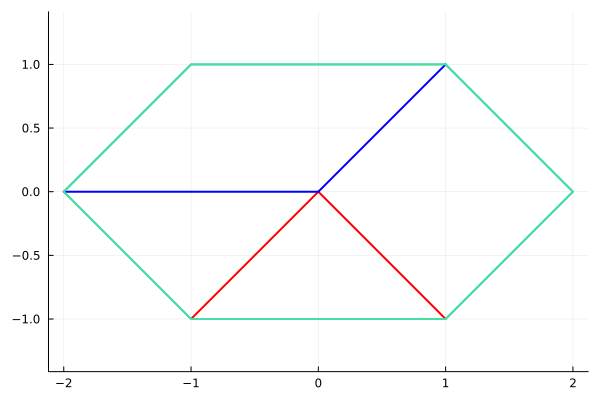

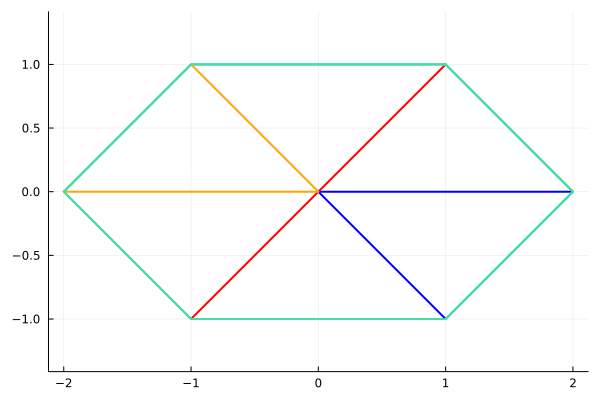

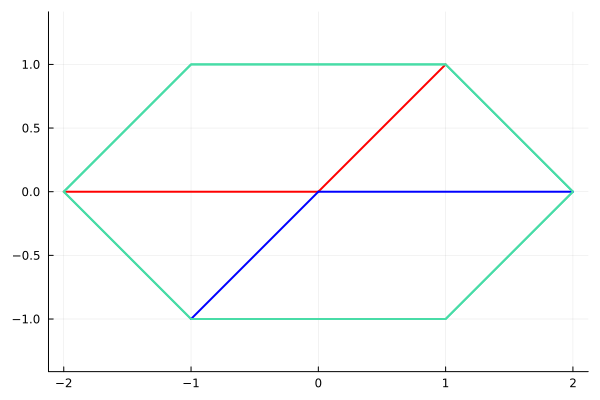

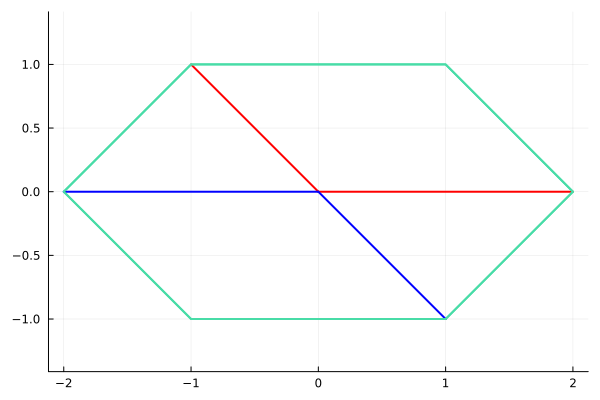

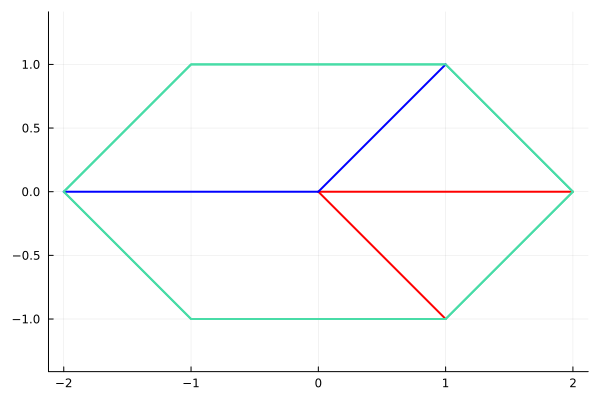

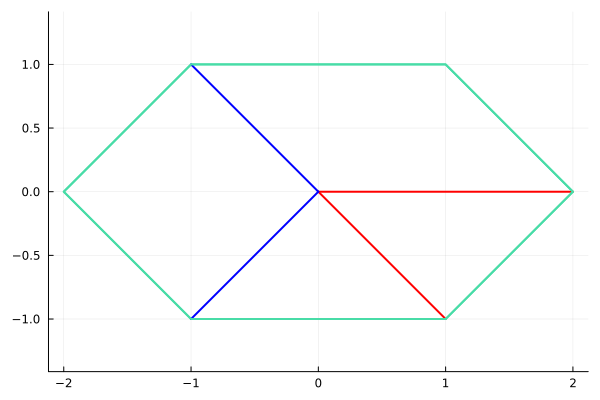

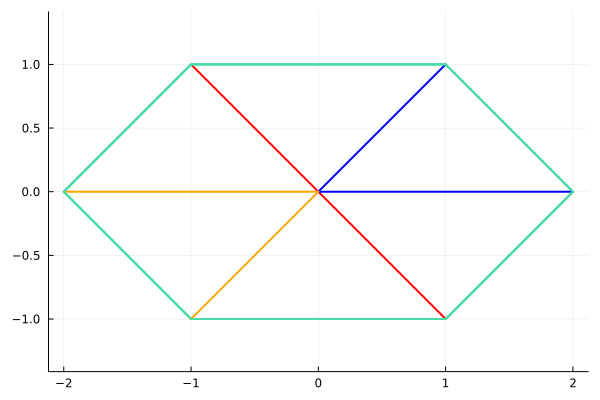

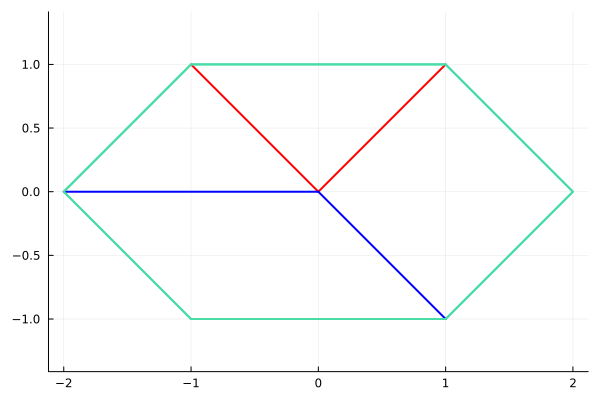

In [88]:
plot_vertices(collect(allowed_vertices),0,0)

# Generic functions

Below, we define some generic functions that will be used later to build the transfer matrix.

In [39]:
"""
has_valid_matching(l, S)

Check if there exists a permutation of the collection S such that each element of l is a subset of the corresponding element in S.

Arguments
l: A collection of sets to match.
S: A collection of sets to match against.

Returns
true if there exists a permutation of S where each element of l is a subset of the corresponding element; false otherwise.
"""
function has_valid_matching(l, S)
    l_list = collect(l)
    S_list = collect(S)
    if length(l_list)>length(S_list)
        return false
    end
    for perm in permutations(S_list)
        if all(issubset(li, si) for (li, si) in zip(l_list, perm))
            return true
        end
    end
    return false
end

has_valid_matching

In [40]:
"""
    shifted_allowed_vertices(allowed_vertices, x, y)

Shift all vertex sets in allowed_vertices from origin (0,0) to (x,y).

# Arguments
- allowed_vertices: A nested collection of sets of vertex coordinates.
  Each innermost set contains tuples (i, j) representing points.
- x: Horizontal shift amount.
- y: Vertical shift amount.

# Returns
- A new Set containing all shifted vertices, preserving the original nested structure.
"""

function shifted_allowed_vertices(allowed_vertices,x,y)

    # shift the allowed_vertices location from (0,0) to (x,y)

    shifted = Set([])
    for vertex_set in allowed_vertices
        shifted_vertex_set = Set([])
        for set in vertex_set
            push!(shifted_vertex_set, Set([(loc[1]+x,loc[2]+y) for loc in set]))
        end
        push!(shifted, shifted_vertex_set)
    end
    return shifted
end

shifted_allowed_vertices (generic function with 1 method)

In [41]:
"""
    is_allowed_vertex(path, new_x, new_y)

Determine if a path together with a candidate new step `(new_x, new_y)` is allowed.

# Arguments
- `path`: A collection of vertices or coordinates representing the current path.
- `new_x`: The x-coordinate of the candidate new vertex.
- `new_y`: The y-coordinate of the candidate new vertex.

# Returns
- `true` if the new vertex can be added to the path according to the rules.
- `false` otherwise.
"""
function is_allowed_vertex(path,new_x,new_y)

    x,y = path[end]

    indices = findall(z -> z == (x,y), path)[1:end-1]
    indices_new = findall(z -> z == (new_x,new_y), path)

    allowed_vertices_xy = shifted_allowed_vertices(allowed_vertices,x,y)

    allowed_vertices_new_x_new_y = shifted_allowed_vertices(allowed_vertices,new_x,new_y)

    if (new_x,new_y) == path[end-1] #No going back
        return false
    end

    if count(p -> p == (new_x, new_y), path) == 3   # A vertex cannot be visited >3 times
        return false
    end

    #Check allowed paths wrt (x,y)

    vertex_set = Set{Any}([Set([path[end-1],(new_x,new_y)])]) #vertex_set related to (x,y)
    for idx in indices
        if idx>1
            push!(vertex_set, Set([path[idx-1],path[idx+1]]))
        else
            push!(vertex_set, Set([path[idx+1]])) #origin
        end
    end

    is_valid = any(has_valid_matching(vertex_set, allowed_vertex_set) for allowed_vertex_set in allowed_vertices_xy)

    #Check allowed paths wrt (new_x,new_y)

    vertex_set_new = Set([Set([(x,y)])]) #vertex_set related to (new_x,new_y)

    for idx in indices_new
        if idx>1
            push!(vertex_set_new, Set([path[idx-1],path[idx+1]]))
        else
            push!(vertex_set_new, Set([path[idx+1]])) #origin
        end
    end


    is_valid *= any(has_valid_matching(vertex_set_new, allowed_vertex_set) for allowed_vertex_set in allowed_vertices_new_x_new_y)


    return is_valid
end

is_allowed_vertex

# Loops of size $k$

Below, we define a function that finds all loops of size $k$ (see Definition 3.1 of [our paper](https://arxiv.org/pdf/2509.04568)) up to reflection and rotation. 
The first move is always forced to the right, and any path that can be reflected along the x-axis is neglected.

In [46]:
"""
find_loops(k)

Find all loops of size k (up to reflection/rotation)

Arguments
k: Size of the loop

Returns
List of loops of size k
"""
function find_loops(k)

    if k == 2
        return [[(0, 0), (2, 0), (0, 0)]]
    end

    moves =  [(2, 0), (1, 1), (-1, 1), (-2, 0), (-1, -1), (1, -1)]

    solutions = []

    function backtrack(path)
        if length(path) == k + 1
            push!(solutions, copy(path))
            return
        end
        x, y = path[end]  # Get current position
        subpath_less_k = path[max(1, length(path) - (k - 2)):end] #partial path

        for (dx, dy) in moves
            new_x, new_y = x + dx, y + dy

            if (x,y) == (2(length(path)-1),0) && dy<0 # Skip paths that can be reflected along x to speed up code later
                continue
            end

            if !is_allowed_vertex(subpath_less_k, new_x, new_y) #Skip all invalid paths wrt to the partial path
                continue
            end

            
            # Keep loops of size k
            if length(path) >= k && is_allowed_vertex(path, new_x, new_y)
                continue
            end

            
            push!(path, (new_x, new_y))
            backtrack(path)
            pop!(path)  # Backtrack
        end
    end

    # Start backtracking from different initial directions
    backtrack([(0, 0), (2, 0)])

    return solutions
end


find_loops

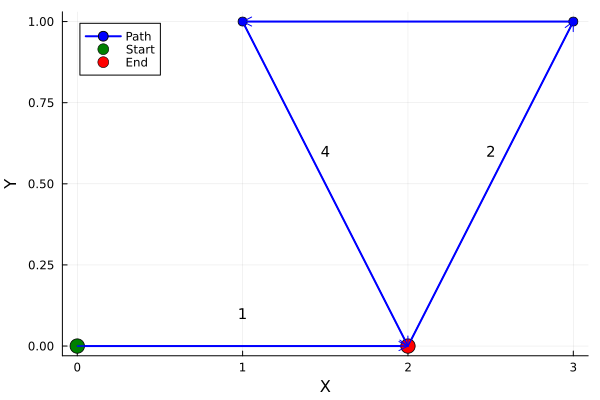

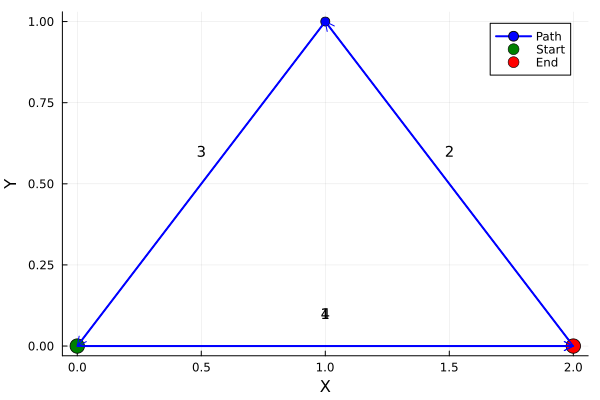

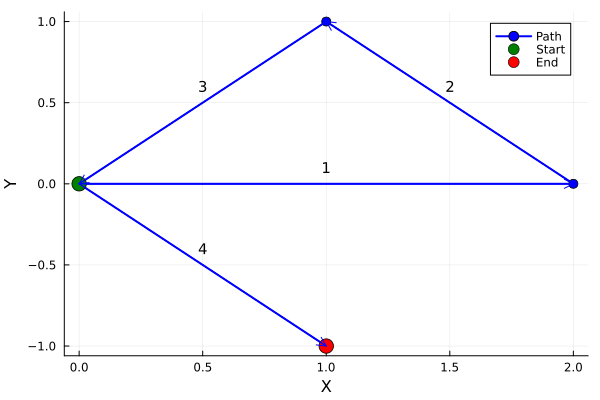

In [89]:
loops_4 = find_loops(4)

plot_all_walks(loops_4)

# Generic functions II

In [90]:
"""
evolve(path)

Generate all possible one-step evolutions of a self-osculating walk (SOW) from the current path.

Arguments
path: A collection of coordinates representing the current walk.

Returns
A collection of new paths, each representing a valid one-step extension of the current path.
"""
function evolve(path)

    moves =  [(2, 0), (1, 1), (-1, 1), (-2, 0), (-1, -1), (1, -1)]
    solutions = []  # List of valid paths
    x, y = path[end]  # Get current position
    
    path_length = length(path)

    # Precompute the index of the current position in path for later use
    idx_current_pos = findfirst(p -> p == (x, y), path)

    for (dx, dy) in moves
        new_x, new_y = x + dx, y + dy

        if !is_allowed_vertex(path, new_x, new_y) #Skip all invalid paths
                continue
        end

        # Create new path and add to solutions
        new_path = copy(path)  # Create a copy of the current path
        push!(new_path, (new_x, new_y))  # Add the new position to the path
        push!(solutions, new_path)  # Store the new valid path
    end

    return solutions
end

evolve

In [91]:
"""
chop_loop(loop)

Generate all proper prefixes (subpaths keeping the starting point) of a loop.

Arguments
loop: A collection representing a loop (e.g., an array of coordinates or elements).

Returns
A vector of sub-loops, where each sub-loop is a prefix of the original loop.
"""
function chop_loop(loop)
    chopped_loop = Vector{Any}()
    for n in 2:length(loop)-1 
        push!(chopped_loop, loop[1:n]) 
    end
    return chopped_loop
end

chop_loop

In [92]:
"""
rotations_reflection(path)

Return all unique rotations and reflections of a given path.

Arguments
path: A collection of coordinates representing the original path (each coordinate is a tuple (x, y)).

Returns
A collection of paths, each being a unique rotation or reflection of the original path.
"""
function rotations_reflection(path)

    rotation_path = [path]
    for a in 1:5
        push!(rotation_path,  [rotate_point(x, y, a) for (x, y) in path])
    end
    
    for a in 0:5
        push!(rotation_path,  [rotate_point(x, -y, a) for (x, y) in path])
    end

    return unique(rotation_path)

end

rotations_reflection

In [93]:
"""
equivalence_k(path, subloops)

Determine which sub-loop a given path is equivalent to.

Arguments
path: A collection of coordinates representing the current path.
subloops: A collection of sub-loops against which to check equivalence.

Returns
The index of the sub-loop in subloops to which path is equivalent. Returns nothing if no equivalent sub-loop is found.
"""
function equivalence_k(path, loop_index_map)
    for n in 1:length(path)-1
        offset = path[n]
        path_translated = [(x - offset[1], y - offset[2]) for (x, y) in path[n:end]]
        
        for rotated in rotations_reflection(path_translated)
            if haskey(loop_index_map, rotated)
                return rotated 
            end
        end
    end
    return nothing
end

equivalence_k

# Transfer matrix

Below, we define the functions that generate the transfer matrix $M_{\leq k}$ (`automata(k)`) and `approximate_mu(k)`, which finds its largest eigenvalue.

In [94]:
"""
automata(k)

Build the transfer matrix to count paths that avoid loops of size less than or equal to k.

Arguments
k: An integer specifying the maximum loop size to avoid.

Returns
A sparse matrix used to count all valid paths without loops of size ≤ k efficiently.
"""
function automata(k)
    loop_list = [loop for n in 4:k for loop in find_loops(n)]


    chopped_loop_list = unique(vcat([chop_loop(loop) for loop in loop_list]...))

    loop_index_map = Dict(loop => idx for (idx, loop) in enumerate(chopped_loop_list))
    
    matrix = spzeros(UInt8, length(loop_index_map), length(loop_index_map))

    for index in 1:length(chopped_loop_list)
        chopped_loop = chopped_loop_list[index]
        for path in evolve(chopped_loop)
            equivalent_state = equivalence_k(path, loop_index_map)
            if equivalent_state==nothing
                println("Found")
            end
            if equivalent_state !== nothing
                index_equivalent_state = loop_index_map[equivalent_state]
                matrix[index_equivalent_state, index] +=1
            end
        end
    end

    return matrix
end


automata

In [95]:
"""
approximate_mu(k)

Estimate the connectivity (growth constant) for walks that avoid loops of size less than or equal to k.

Arguments
k: An integer specifying the maximum loop size to avoid.

Returns
A numerical value representing the approximate connectivity of the walk.
"""

function approximate_mu(k)

    vals, _ = eigs(automata(k), nev=1, which=:LM, maxiter=10000, tol=1e-9)

    return vals[1]
    
end

approximate_mu (generic function with 1 method)

In [96]:
approximate_mu(4)

4.811517752057149 + 0.0im